In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
from typing import Sequence
import functools

from dataclasses import dataclass

import os
import sys
if "notebooks" in os.path.abspath('.'):
    sys.path.append('../')
from traces import mtbench_mixtral_utils

In [3]:
traces = mtbench_mixtral_utils.load_all()

Text(0.5, 1.0, 'Mixtral on MTBench')

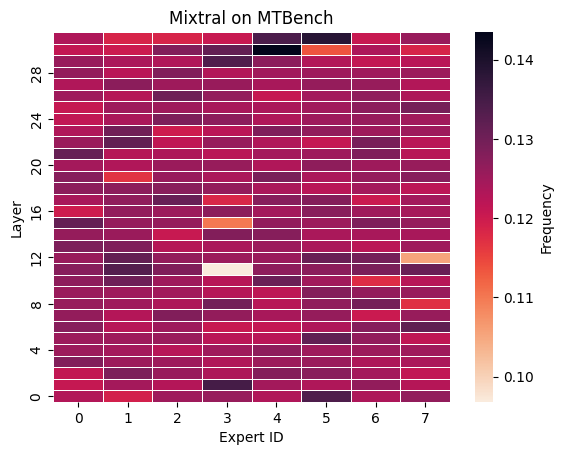

In [4]:
expert_counts_by_layer = sum(trace.expert_counts_by_layer() for trace in traces.values())
expert_freq_by_layer = expert_counts_by_layer / expert_counts_by_layer.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(expert_freq_by_layer, linewidths=.5, cmap='rocket_r',
                 cbar_kws={'label': 'Frequency'})
ax.invert_yaxis()
ax.set_yticks(0.5 + np.arange(0, 32, 4), np.arange(0, 32, 4))
plt.xlabel("Expert ID")
plt.ylabel("Layer")
plt.title("Mixtral on MTBench")

Text(0, 0.5, 'Standard Deviation\nof Expert Frequencies')

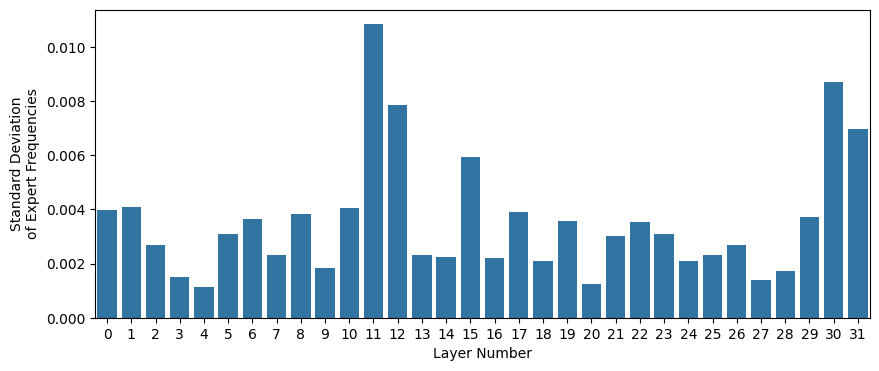

In [526]:
plt.figure(figsize=(10, 4))
sns.barplot(x=np.arange(0, 32), y=expert_freq_by_layer.std(axis=1))
plt.xlabel("Layer Number")
plt.ylabel("Standard Deviation\nof Expert Frequencies")

In [527]:
def p_next_expert_given_previous_experts(traces: dict, k=2):
    # (layer, previous_expert_0, previous_expert_1, next_expert)
    trace = next(iter(traces.values()))
    combinations = list(itertools.combinations(list(range(trace.num_experts)), k))
    num_combinations = len(combinations)
    combination_to_idx = {c: i for i, c in enumerate(combinations)}
    counts = np.zeros((trace.num_layers, num_combinations, trace.num_experts), dtype=np.uint32)
    for trace_name, trace in traces.items():
        # trace = trace.without_prefix()
        for layer_id, cur_experts, next_experts in zip(trace.layer_ids, trace.expert_ids, trace.expert_ids[1:]):
            # assert len(cur_experts) == 1, f'{len(cur_experts)} should be 1 for {trace_name}'
            for per_token_cur_experts, per_token_next_experts in zip(cur_experts, next_experts):
                combination = tuple(sorted(per_token_cur_experts))
                combination_idx = combination_to_idx[combination]
                counts[layer_id, combination_idx, per_token_next_experts] += 1

    sum = counts.sum(axis=-1)
    divisor = np.maximum(sum, np.ones_like(sum)) # Avoid dividing by 0
    probabilities = counts / divisor[:, :, np.newaxis]
    return probabilities, combination_to_idx

probabilities, experts_to_idx = p_next_expert_given_previous_experts(traces)

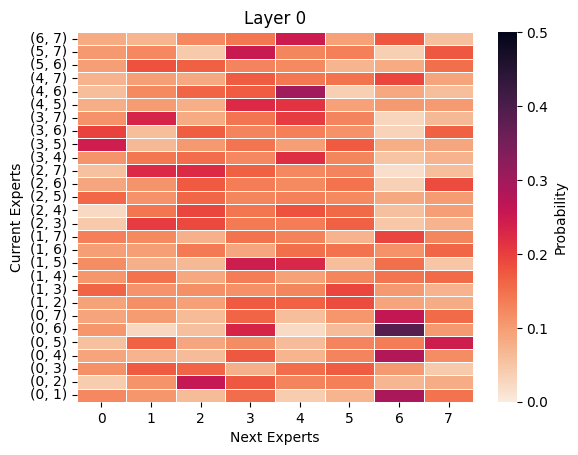

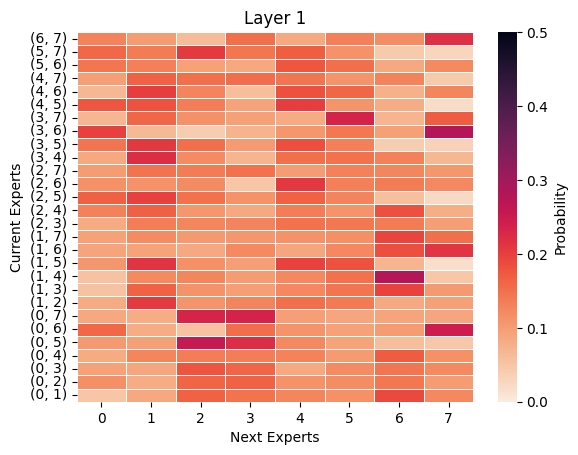

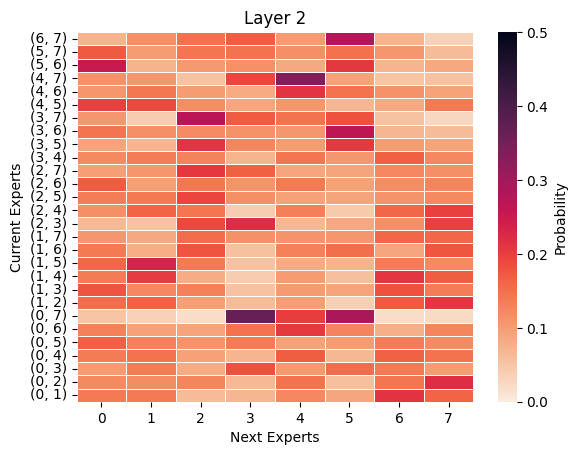

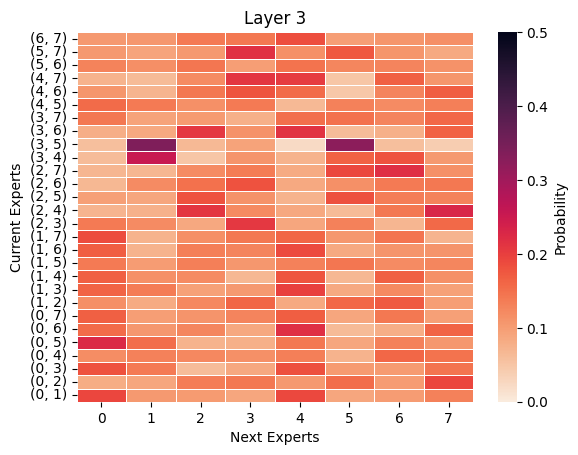

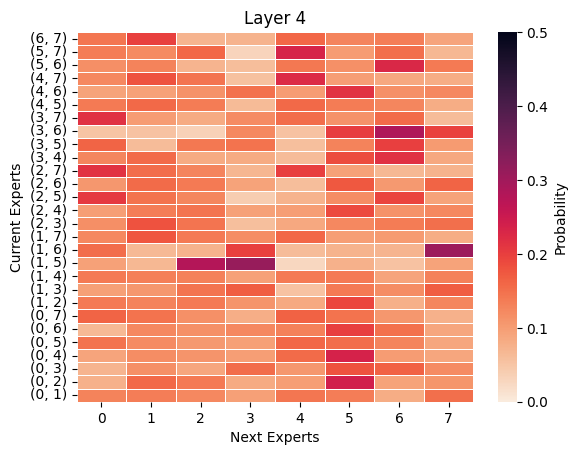

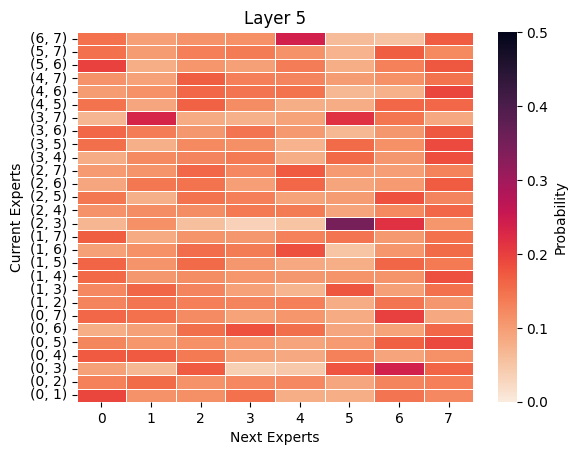

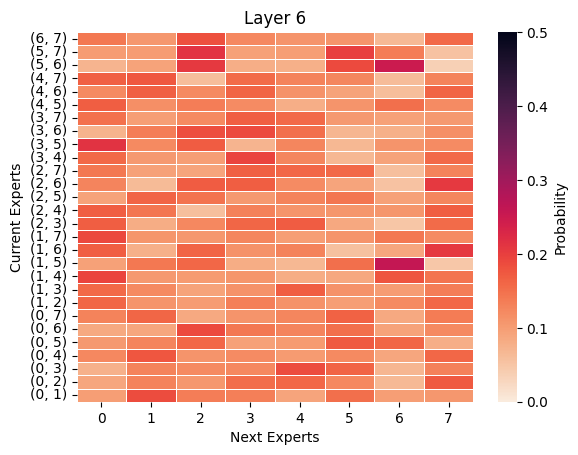

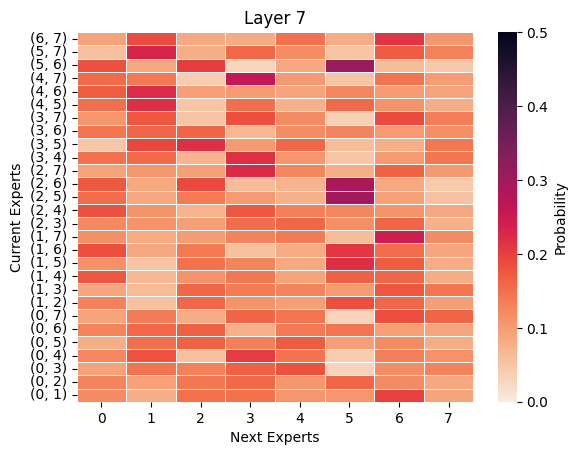

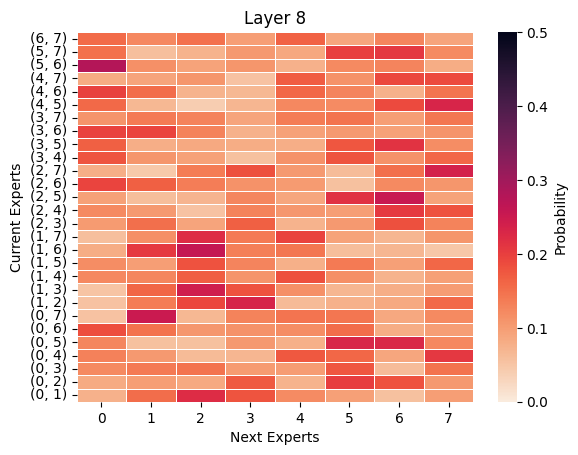

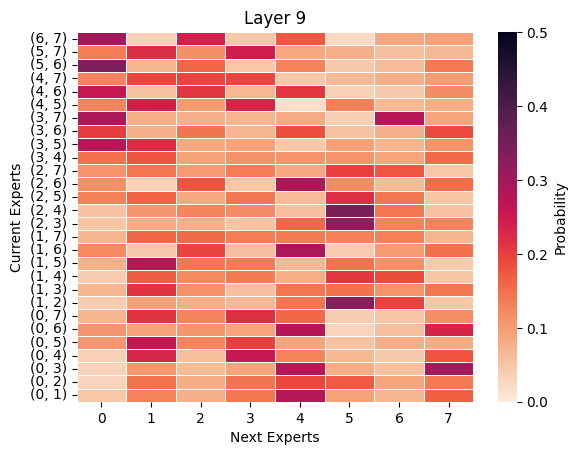

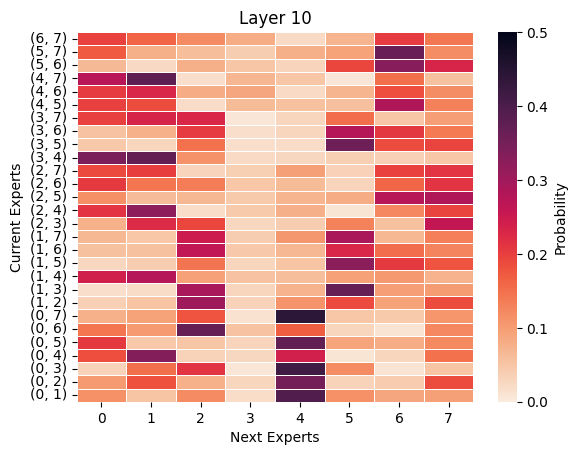

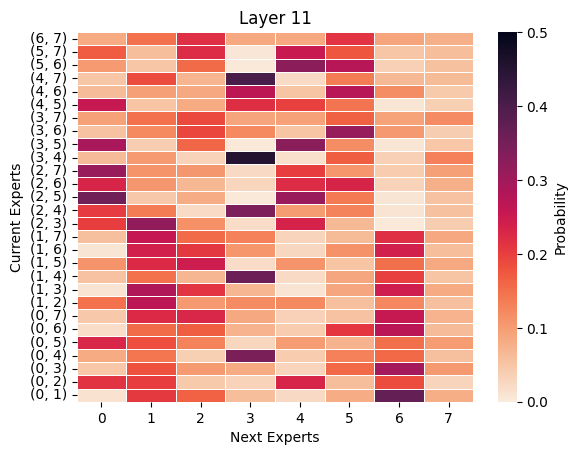

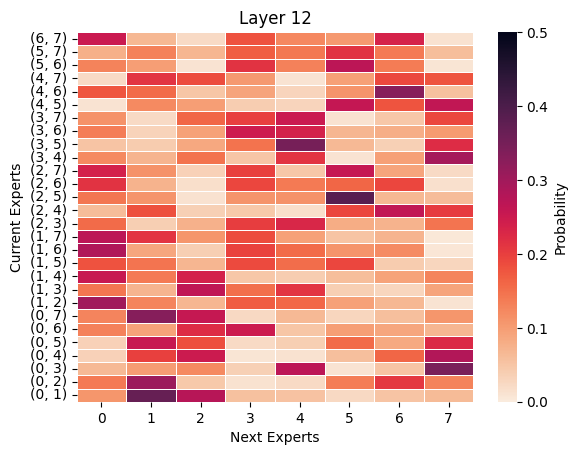

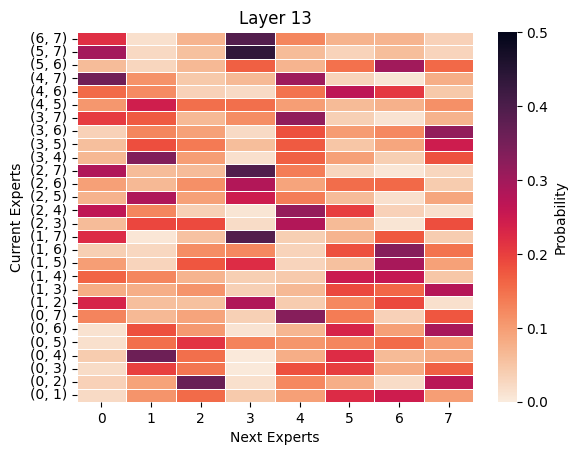

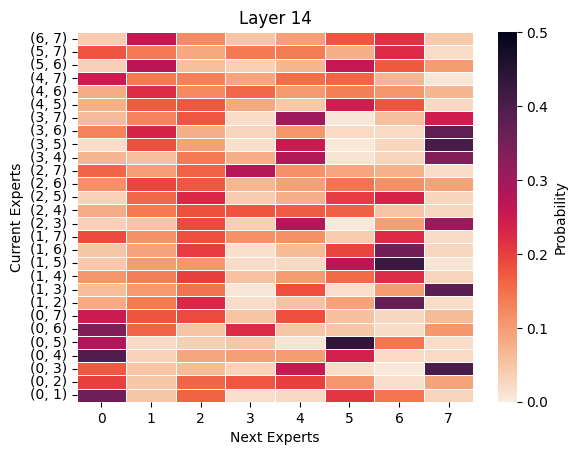

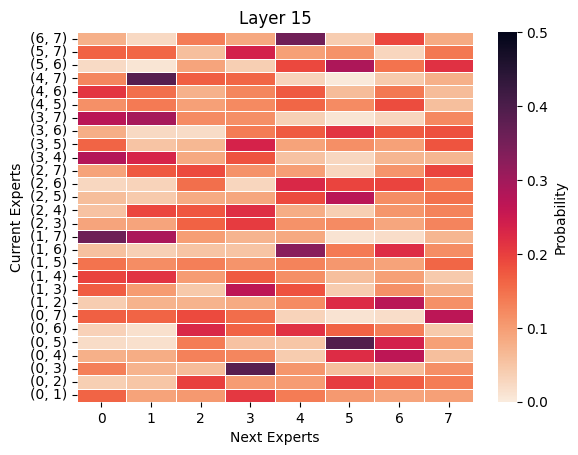

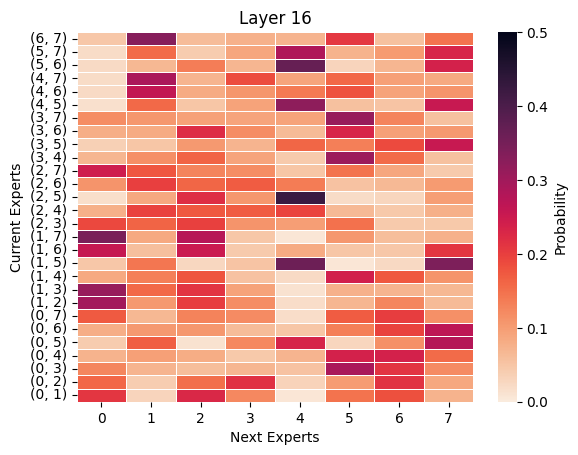

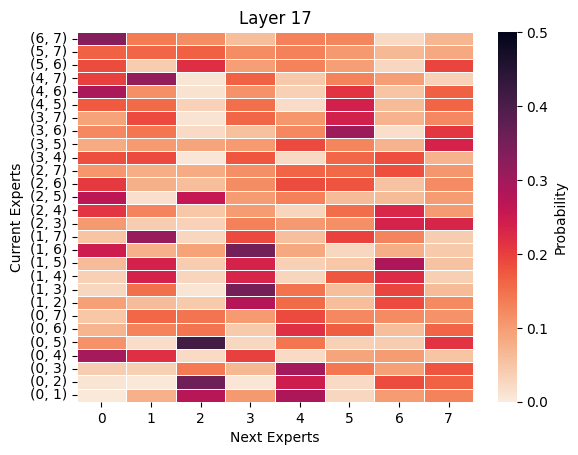

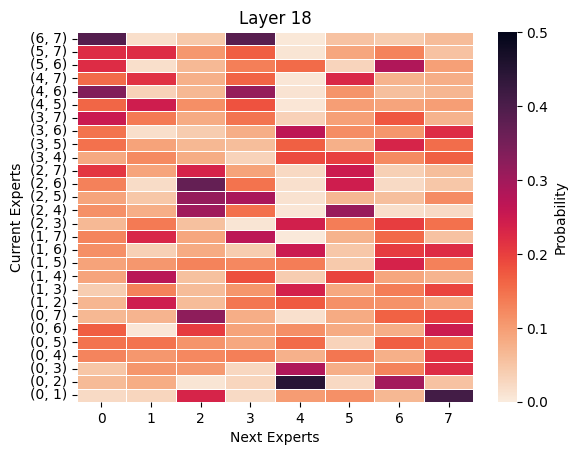

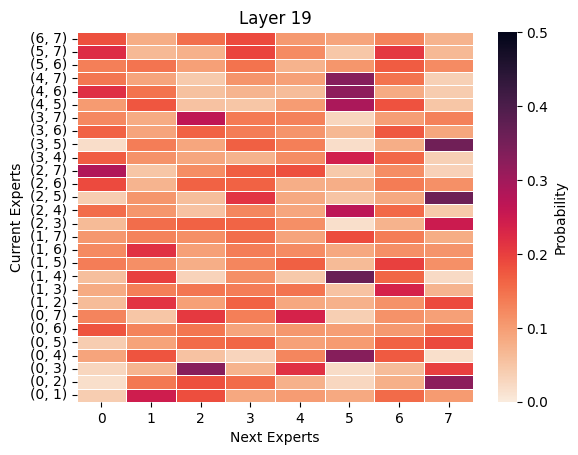

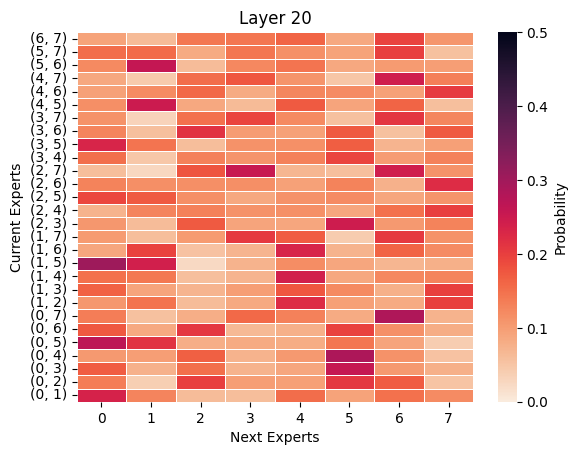

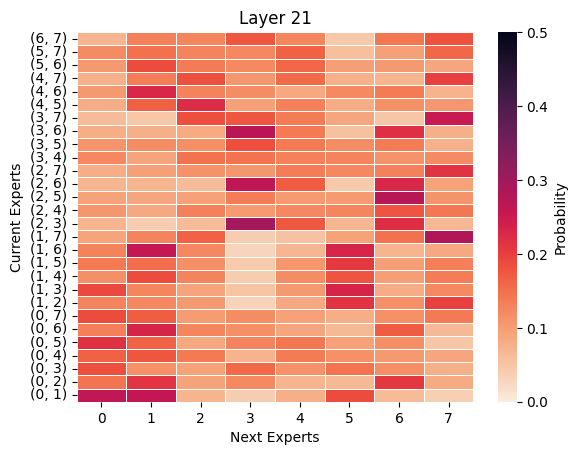

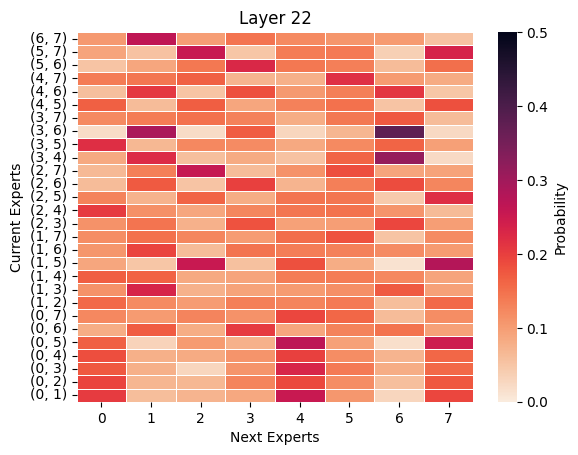

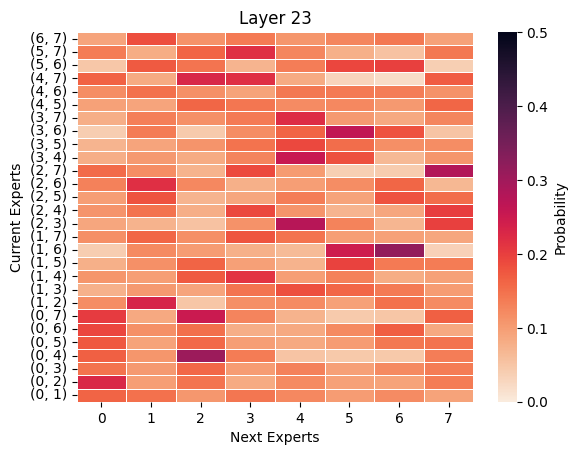

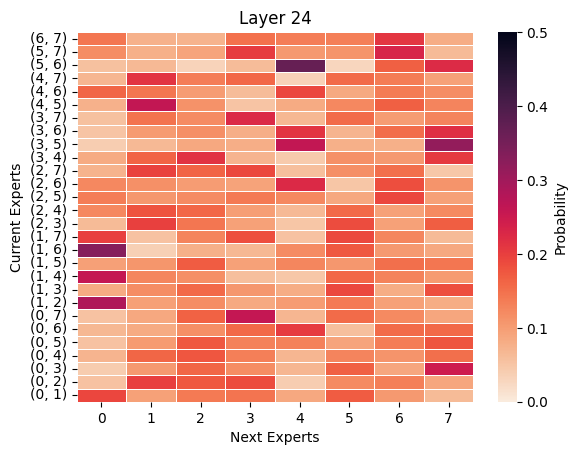

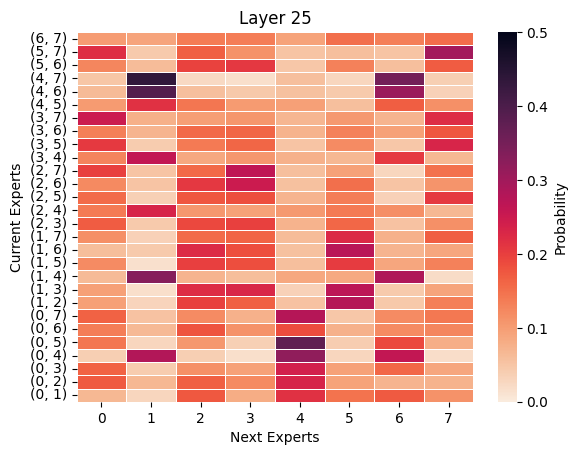

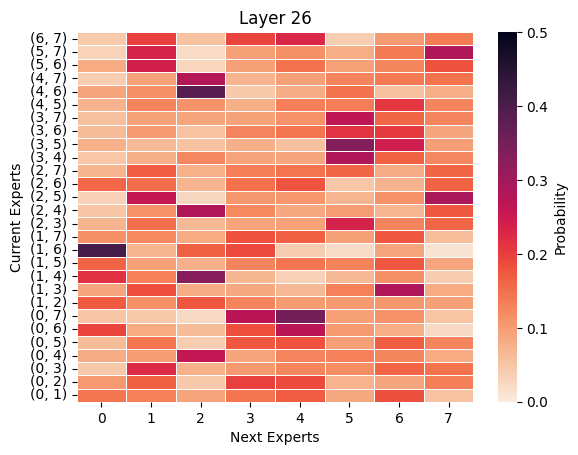

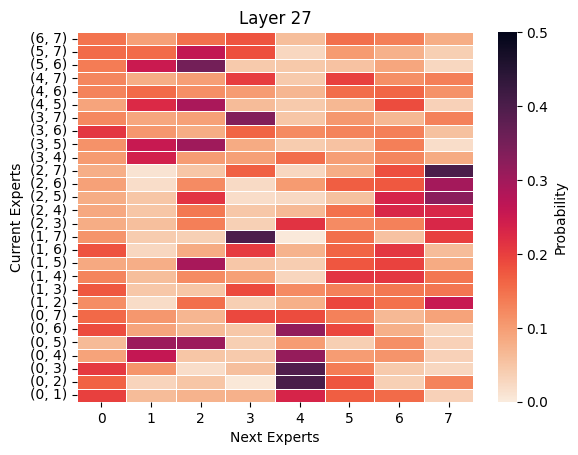

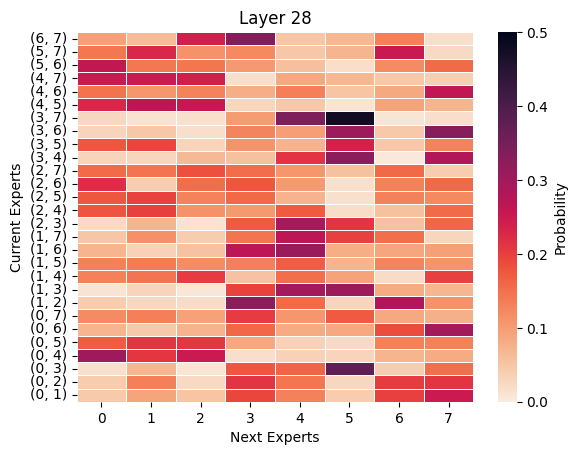

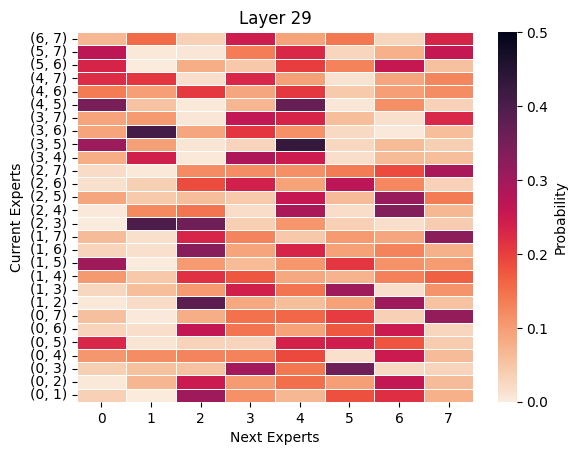

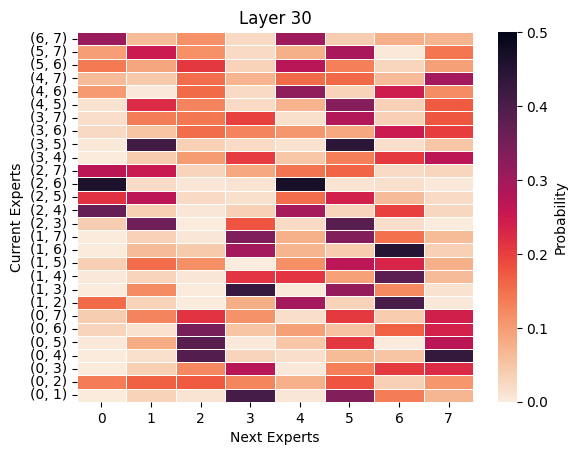

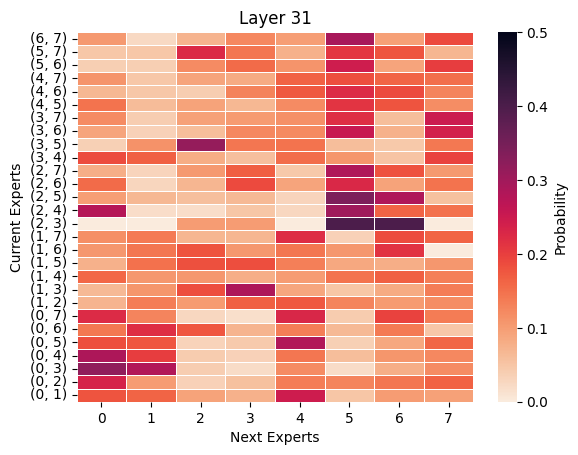

In [528]:
def plot_probabilities(layer_id, probabilities, experts_to_idx):
    ax = sns.heatmap(probabilities[layer_id], linewidths=.5, cmap='rocket_r',
                     cbar_kws={'label': 'Probability'}, vmin=0, vmax=0.5)
    ax.invert_yaxis()
    plt.xlabel("Next Experts")
    plt.ylabel("Current Experts")
    plt.title(f"Layer {layer_id}")
    
    yticks = np.arange(0, len(experts_to_idx), 1)
    idx_to_experts = {i: e for e, i in experts_to_idx.items()}
    yticklabels = [idx_to_experts[i] for i in yticks]
    ax.set_yticks(yticks + 0.5, yticklabels)
    # plt.xticks(fontsize=5)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()

for i in range(32):
    plot_probabilities(i, probabilities, experts_to_idx)

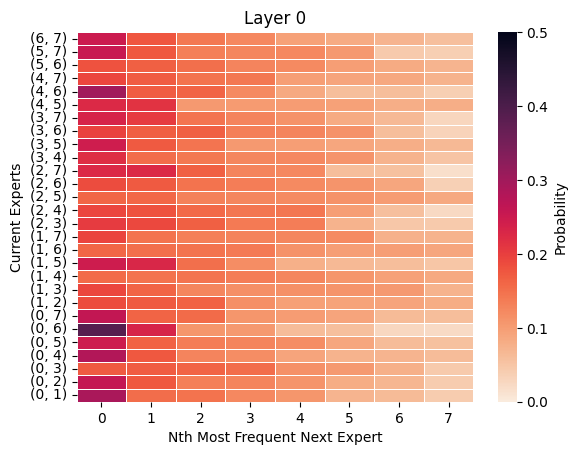

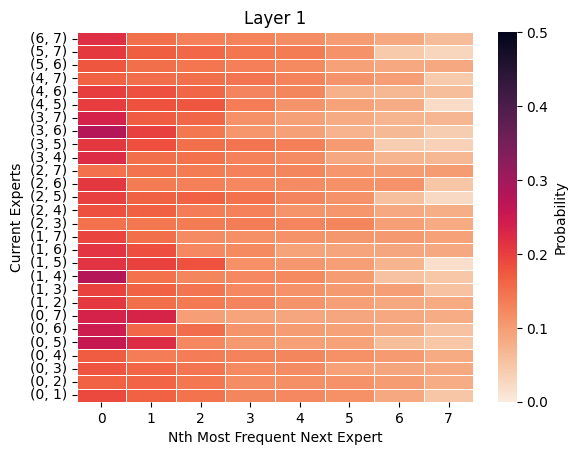

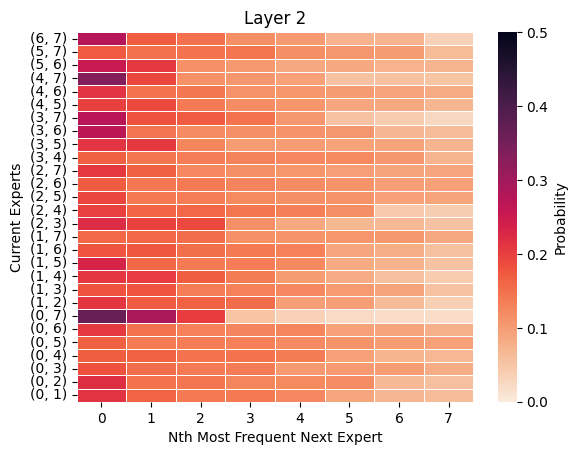

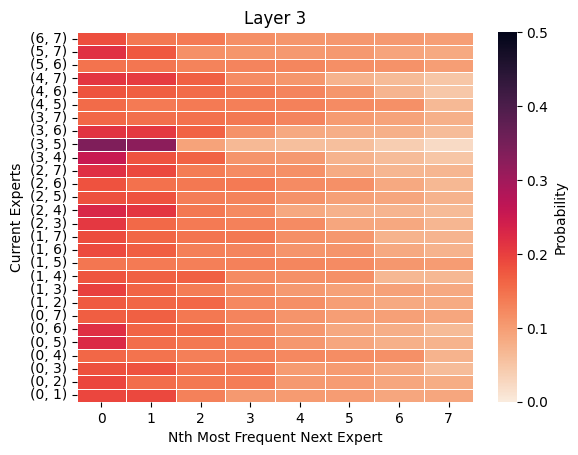

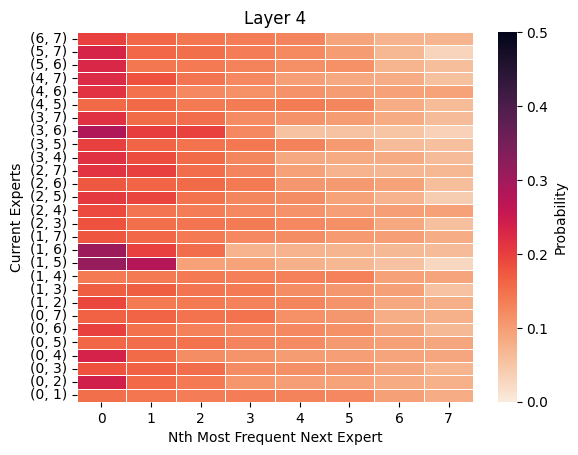

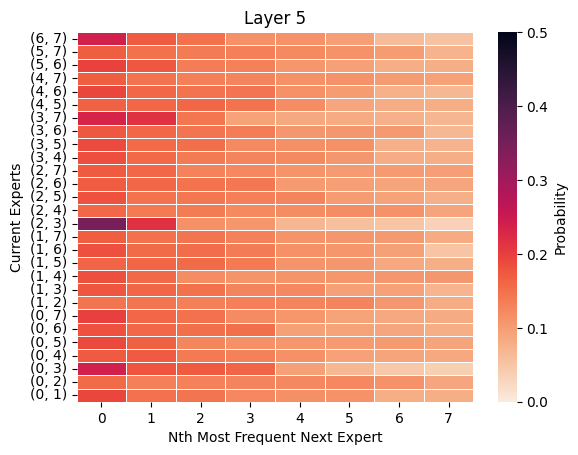

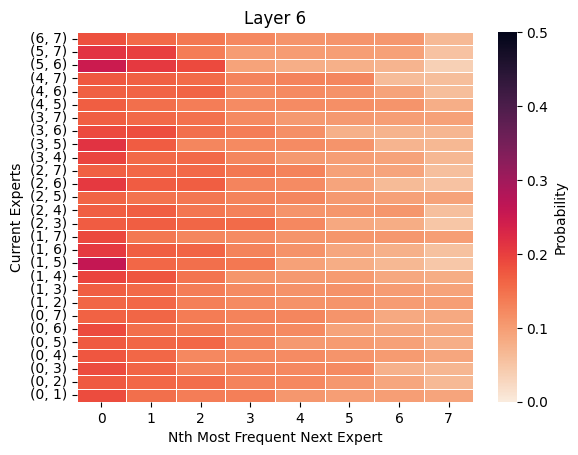

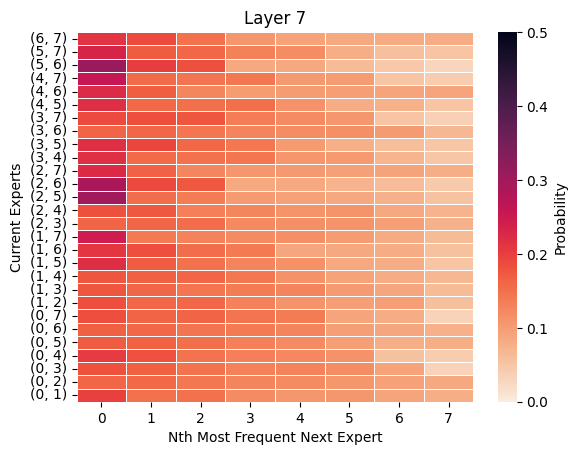

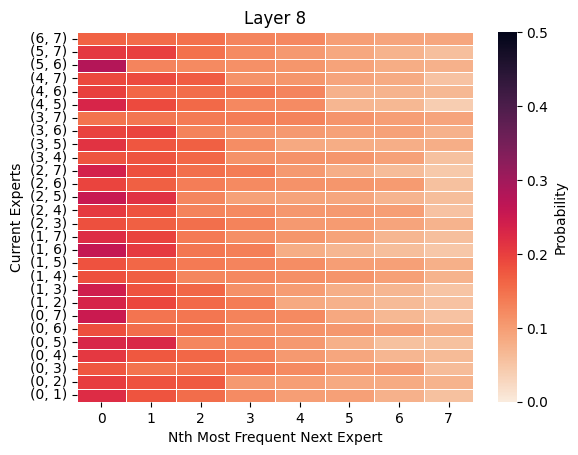

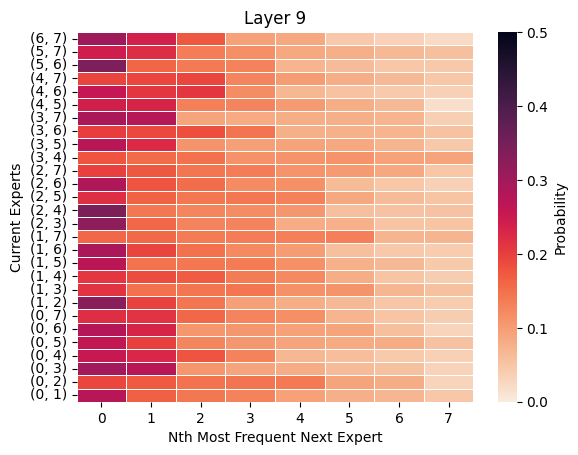

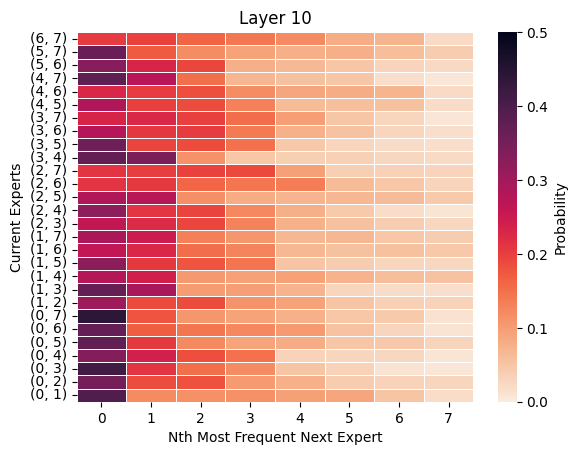

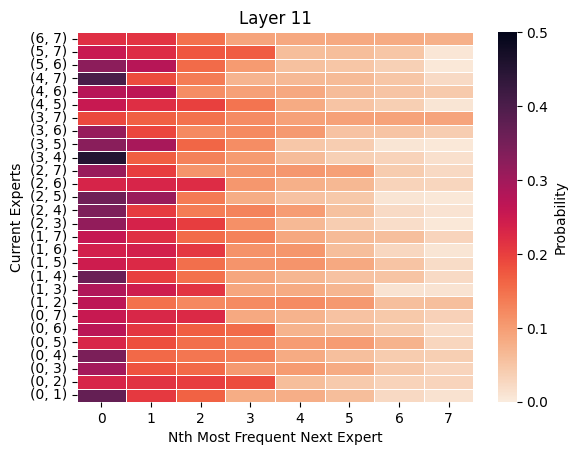

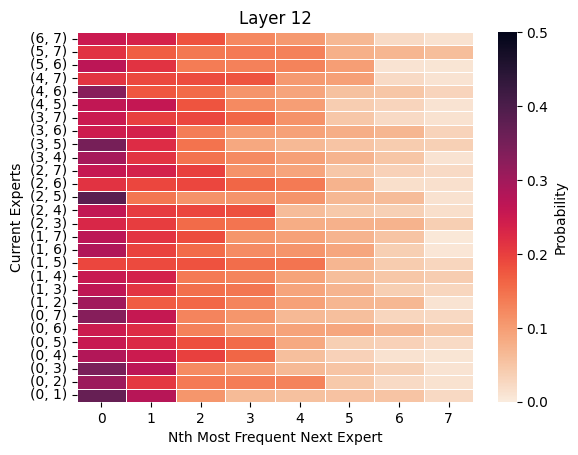

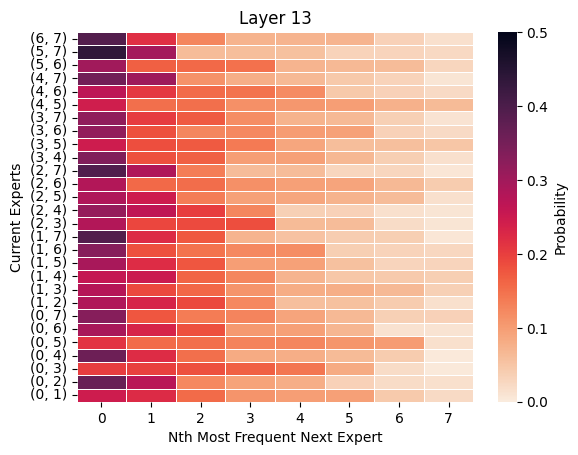

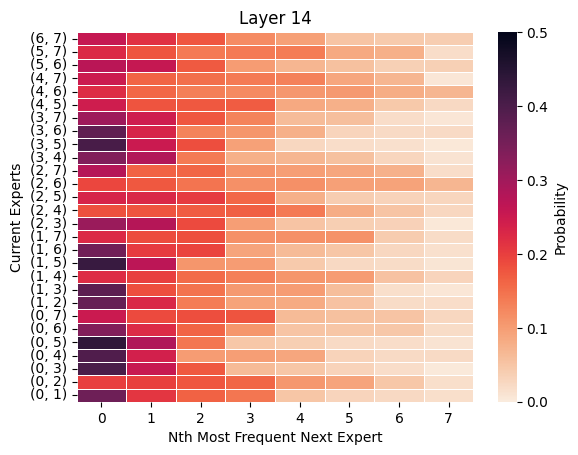

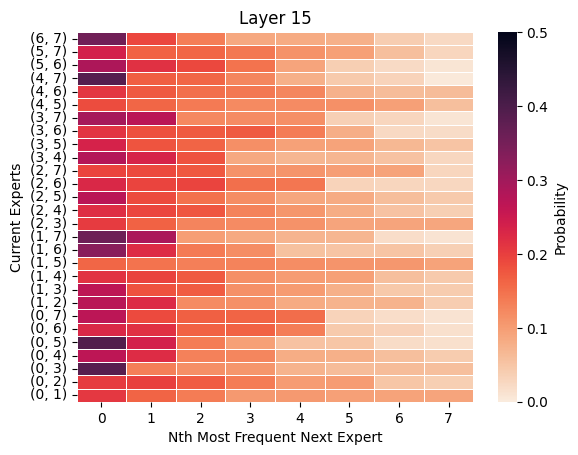

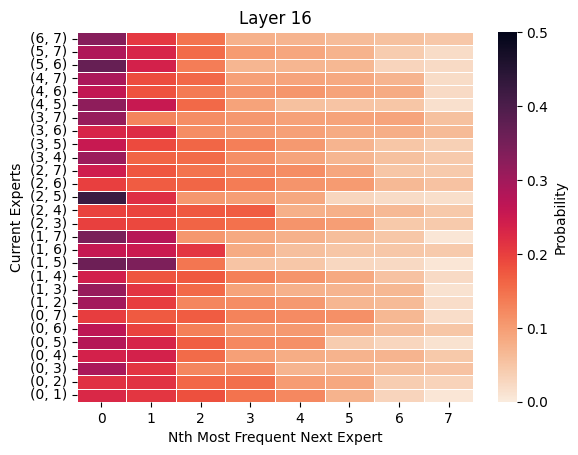

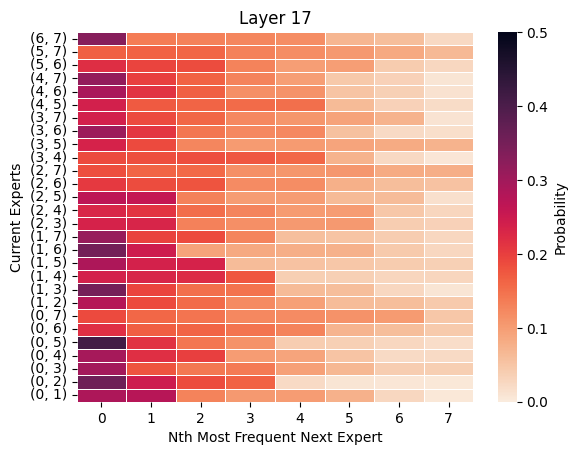

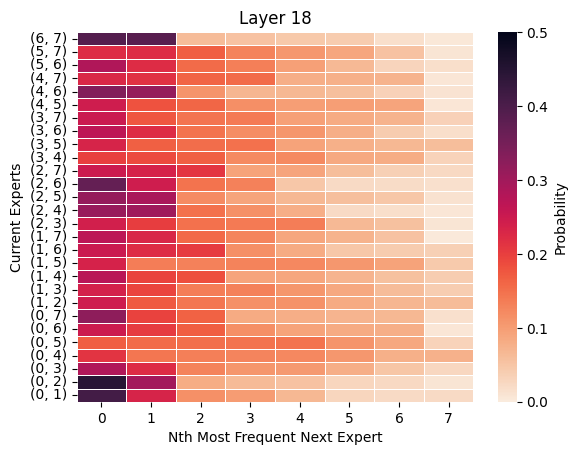

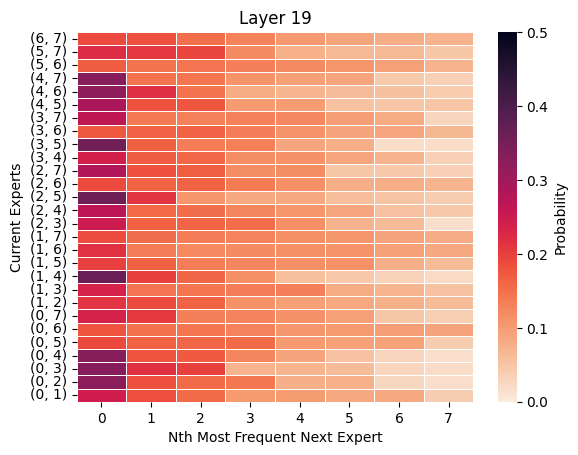

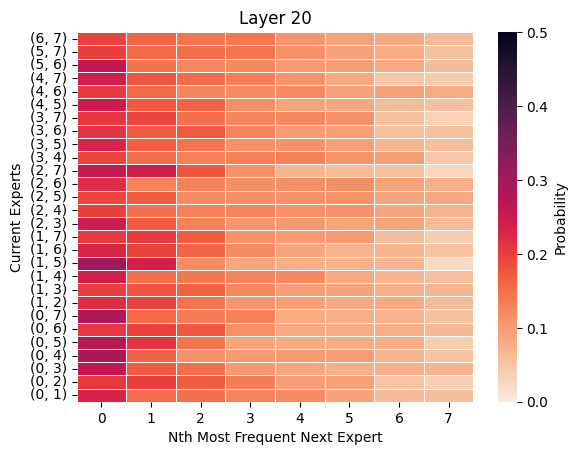

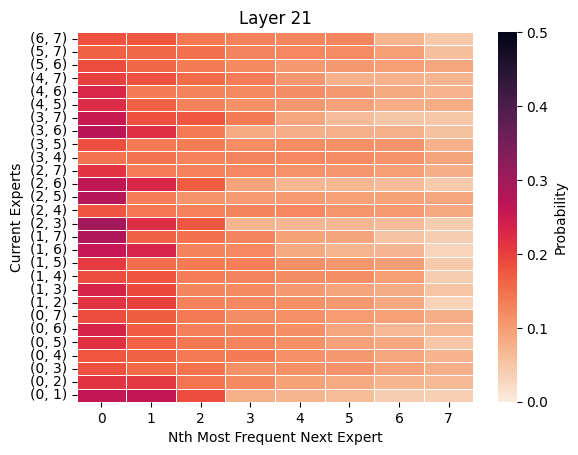

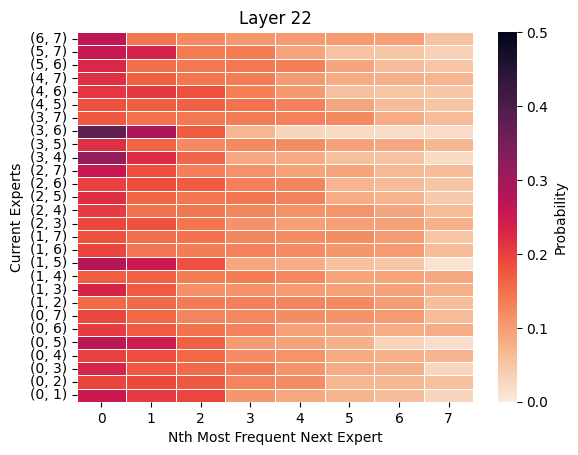

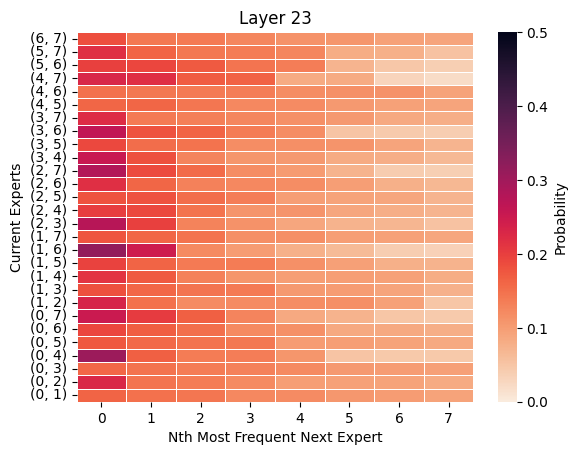

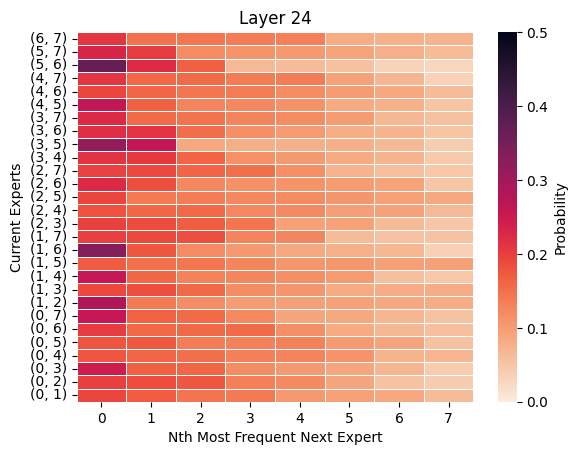

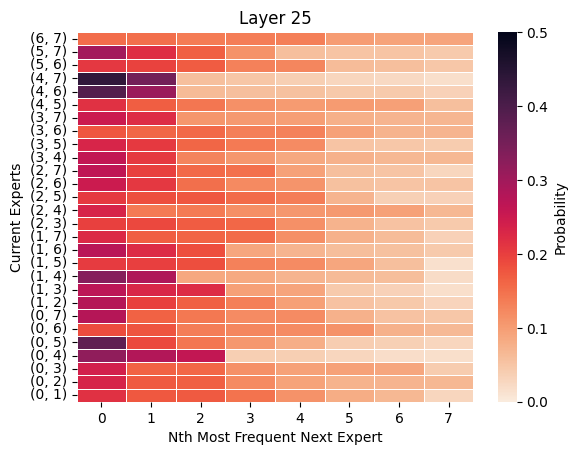

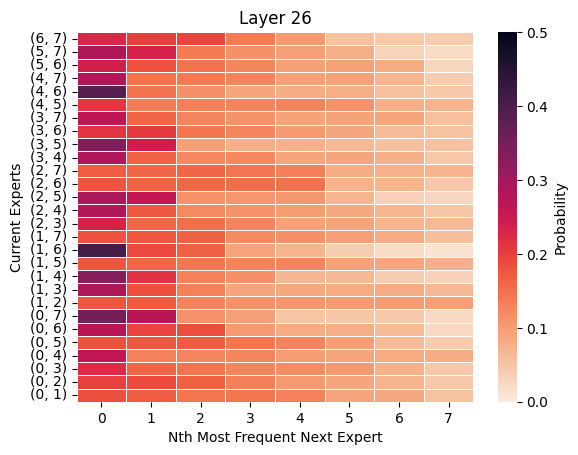

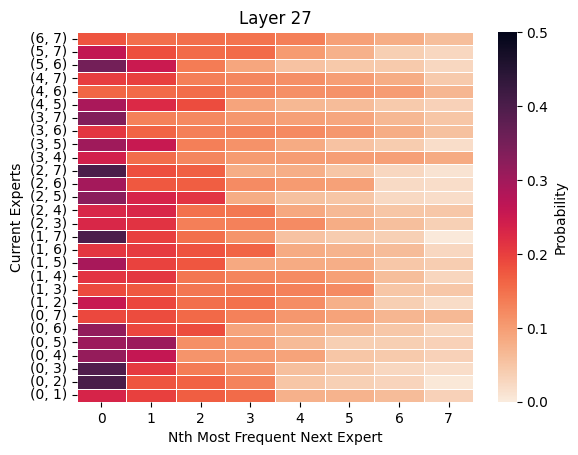

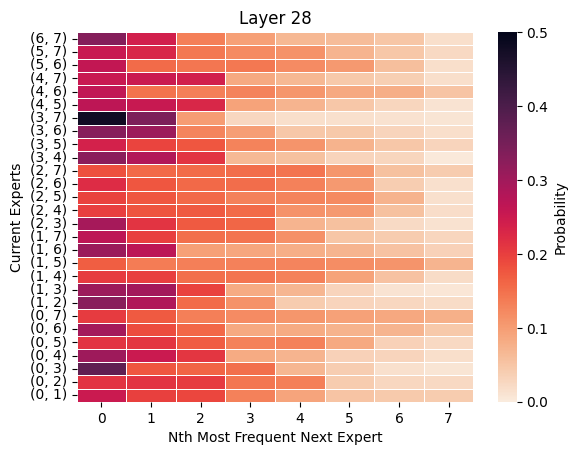

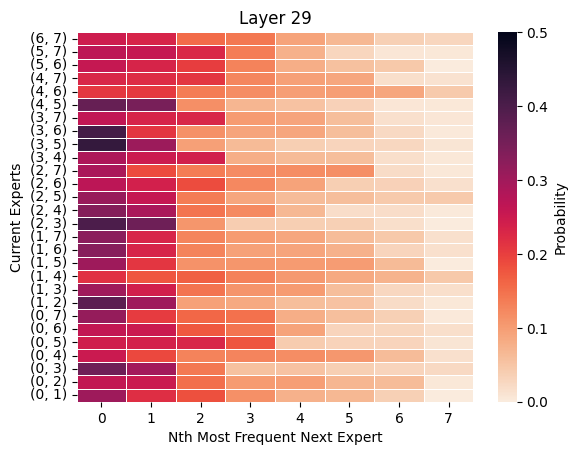

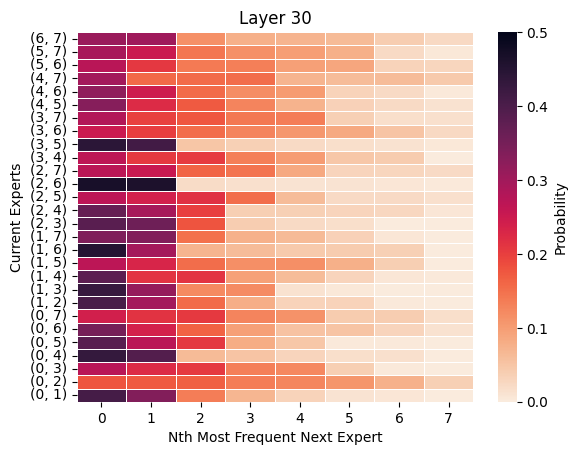

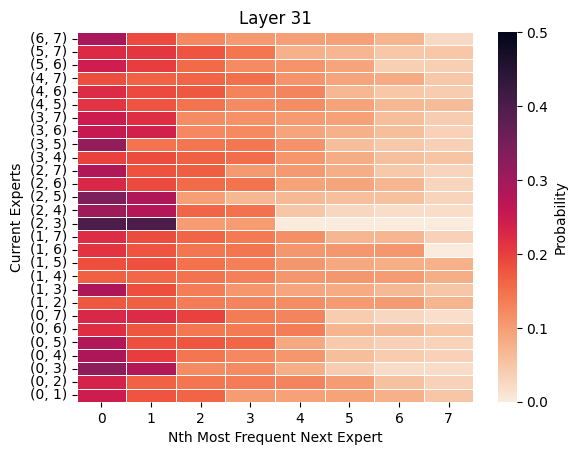

In [437]:
def plot_probabilities(layer_id, probabilities, experts_to_idx):
    ax = sns.heatmap(probabilities[layer_id], linewidths=.5, cmap='rocket_r',
                     cbar_kws={'label': 'Probability'}, vmin=0, vmax=0.5)
    ax.invert_yaxis()
    plt.xlabel("Nth Most Frequent Next Expert")
    plt.ylabel("Current Experts")
    plt.title(f"Layer {layer_id}")
    
    yticks = np.arange(0, len(experts_to_idx), 1)
    idx_to_experts = {i: e for e, i in experts_to_idx.items()}
    yticklabels = [idx_to_experts[i] for i in yticks]
    ax.set_yticks(yticks + 0.5, yticklabels)
    # plt.xticks(fontsize=5)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()

sorted_probabilities = np.sort(probabilities, axis=-1)[:, :, ::-1]
for i in range(32):
    plot_probabilities(i, sorted_probabilities, experts_to_idx)

In [ ]:
# Single sequence

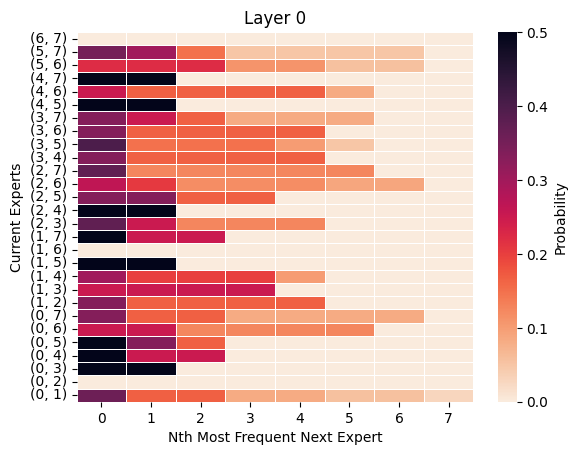

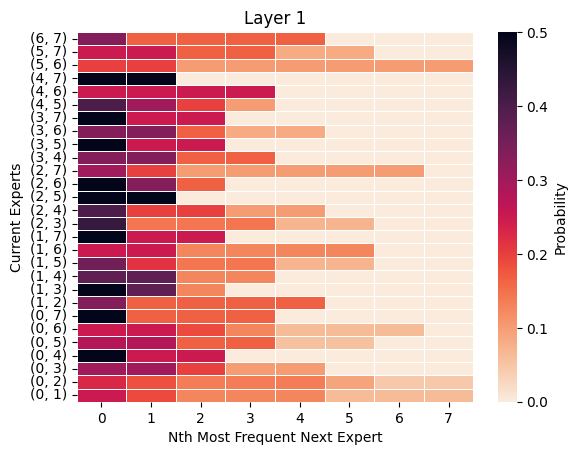

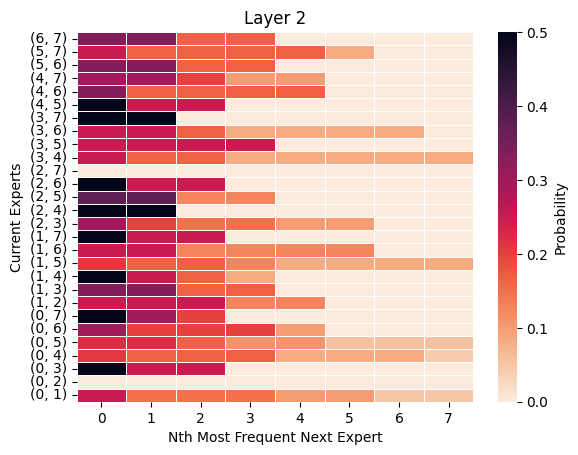

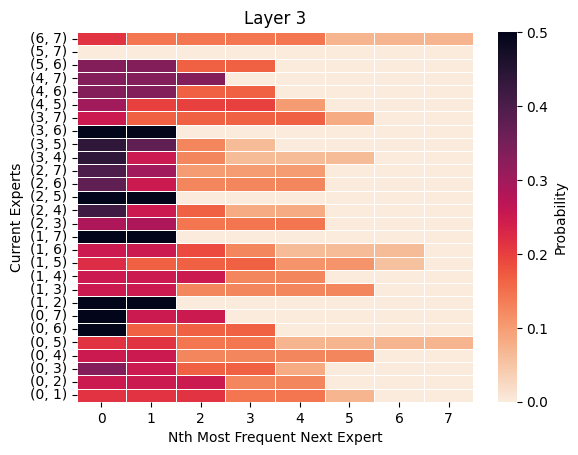

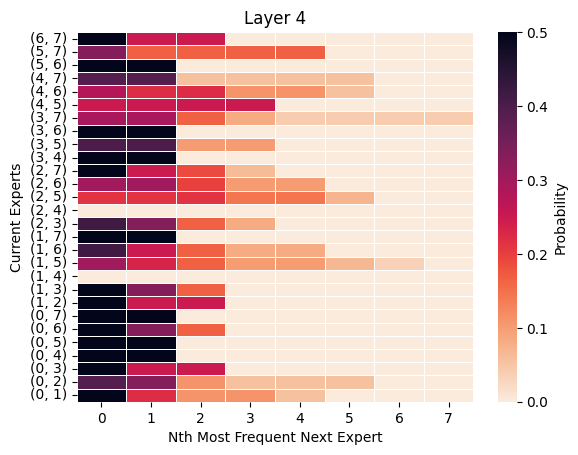

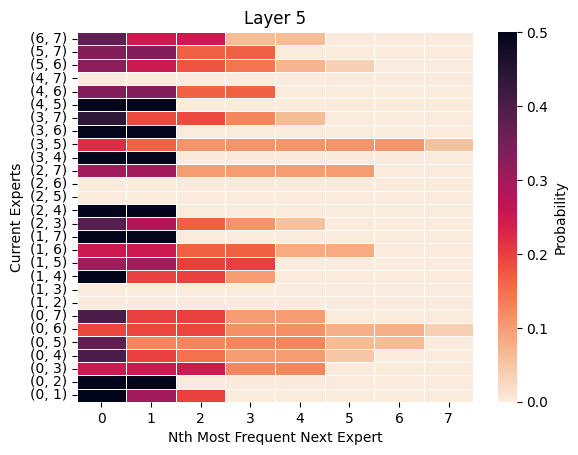

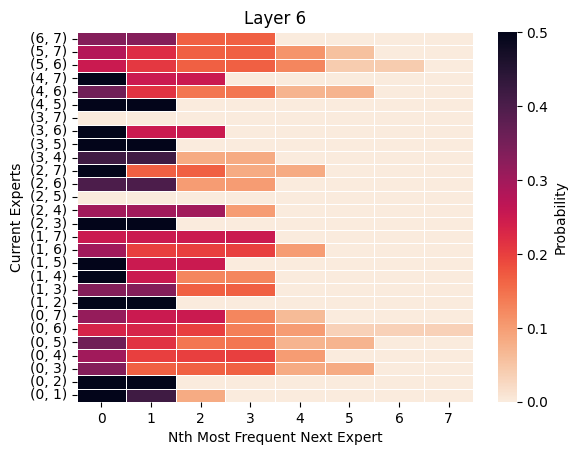

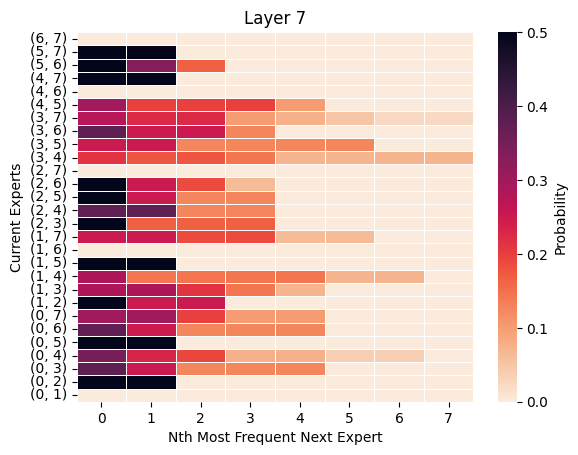

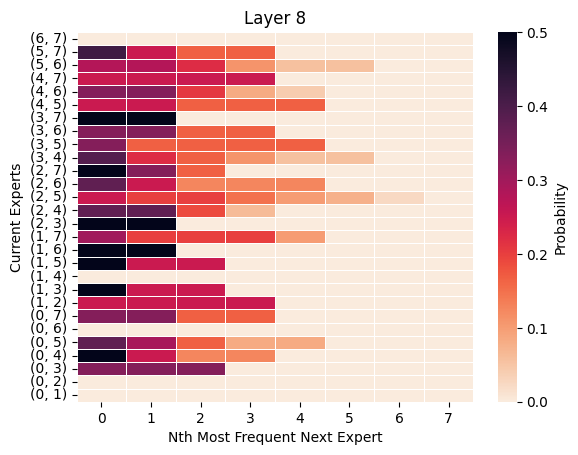

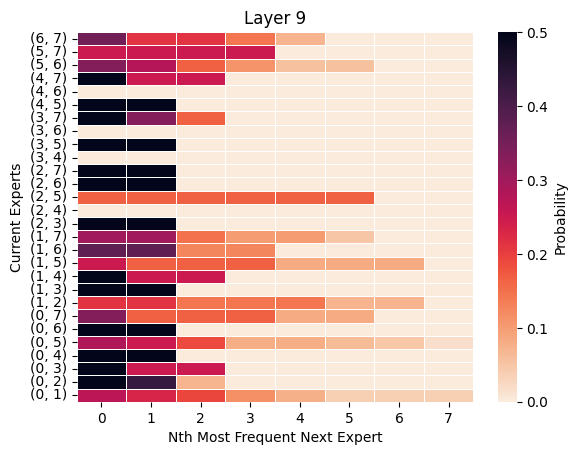

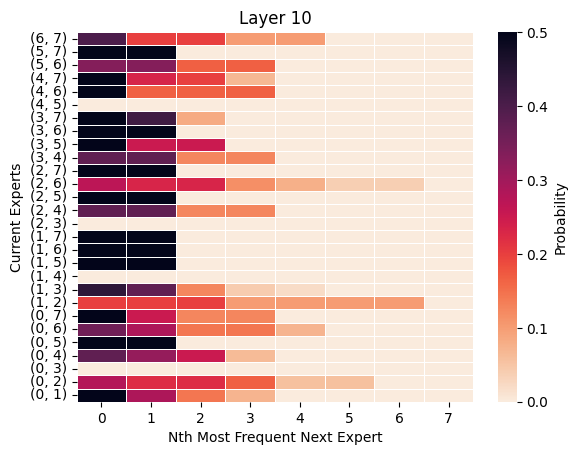

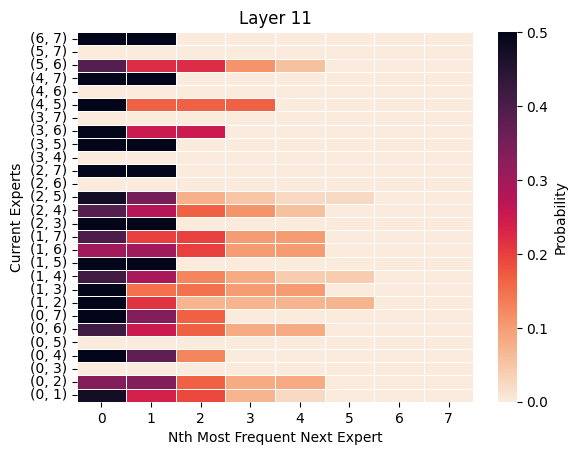

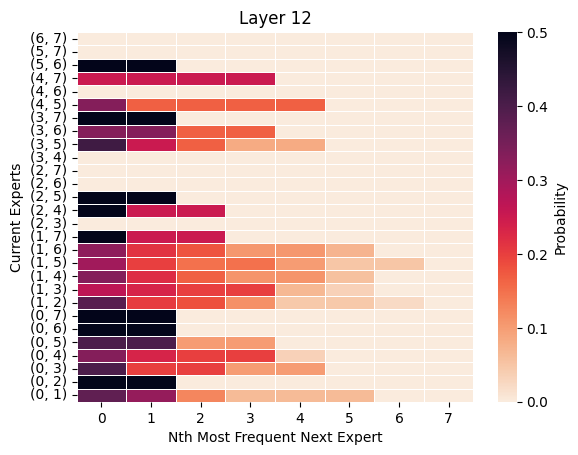

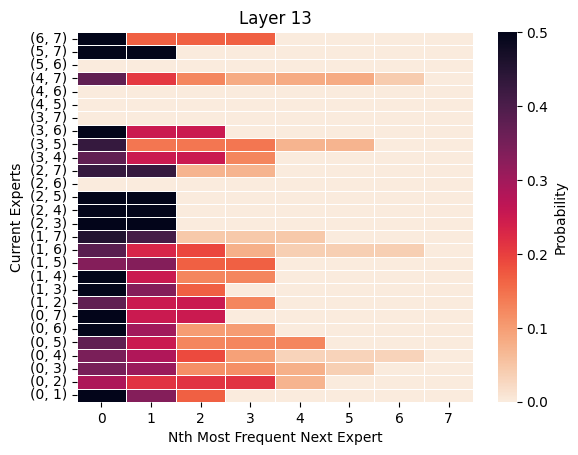

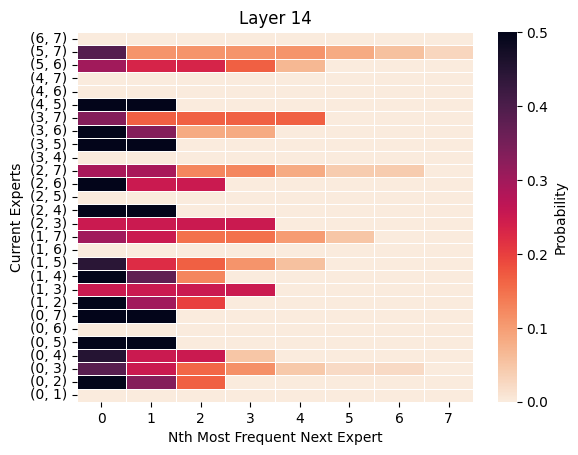

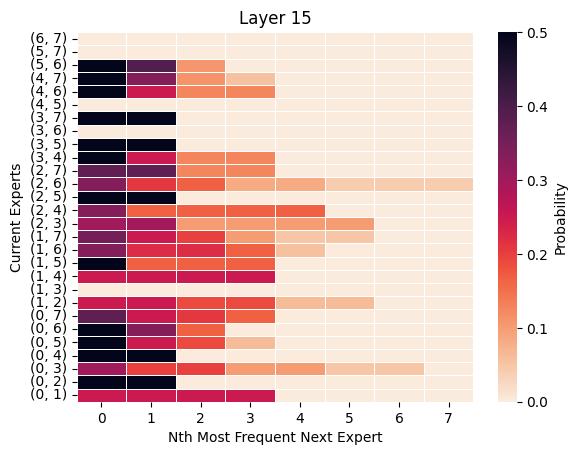

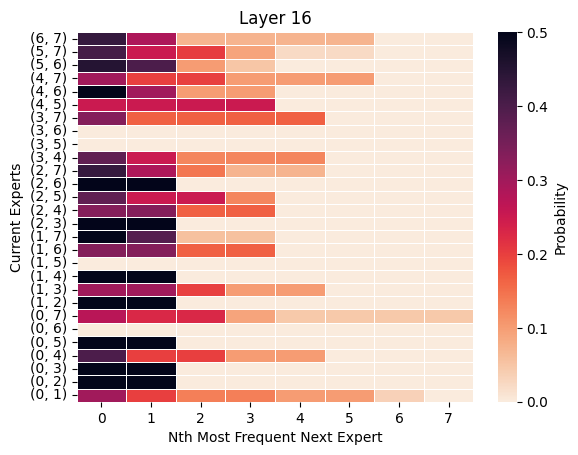

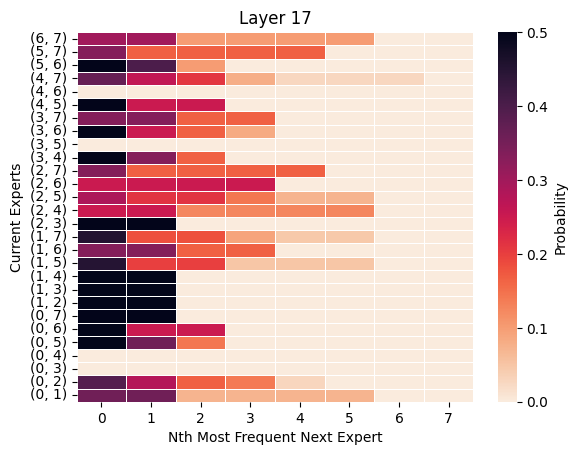

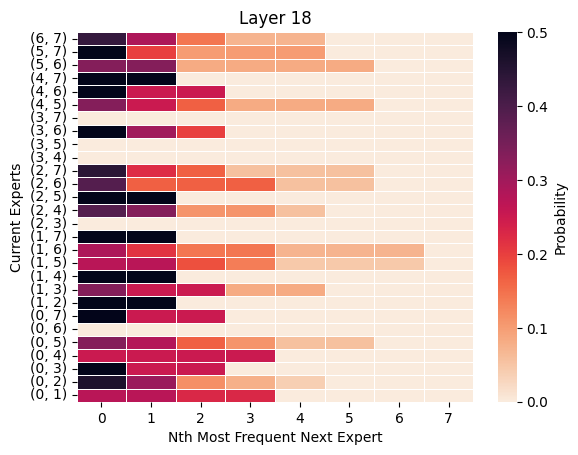

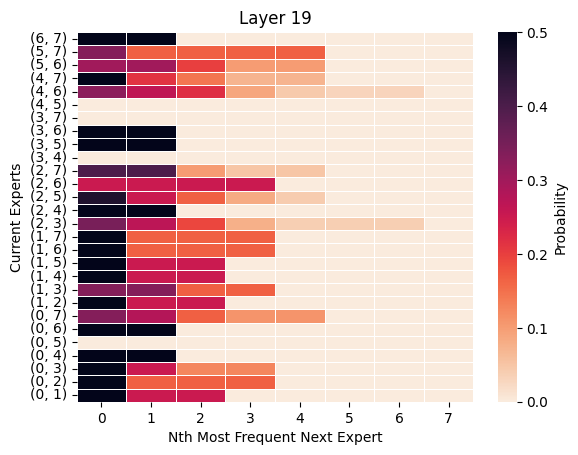

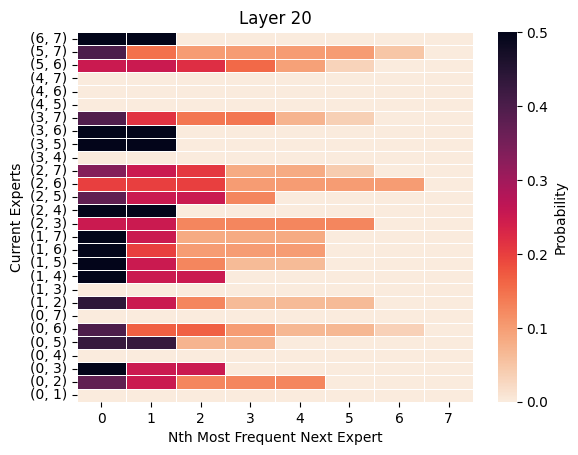

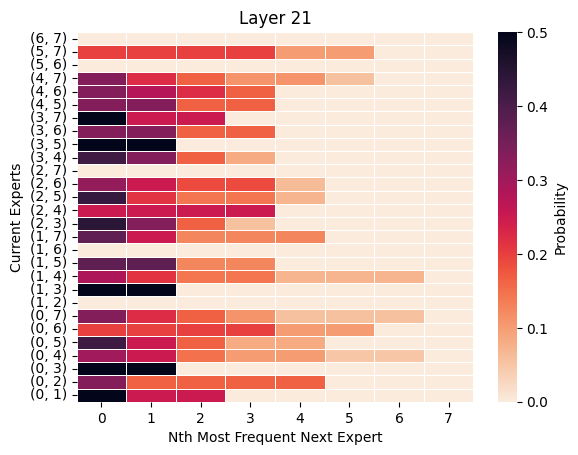

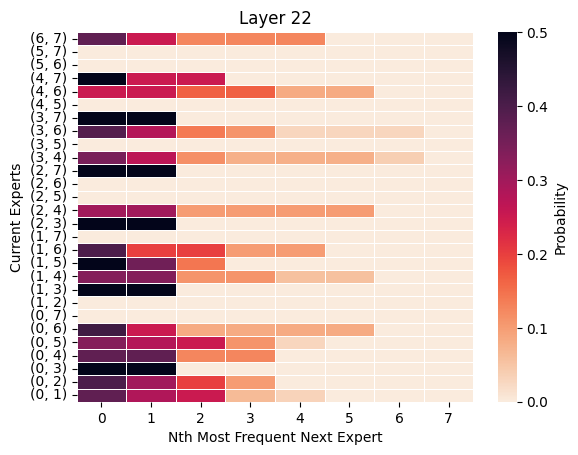

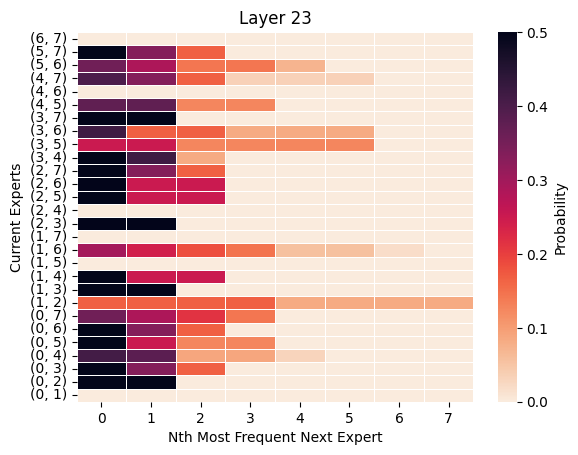

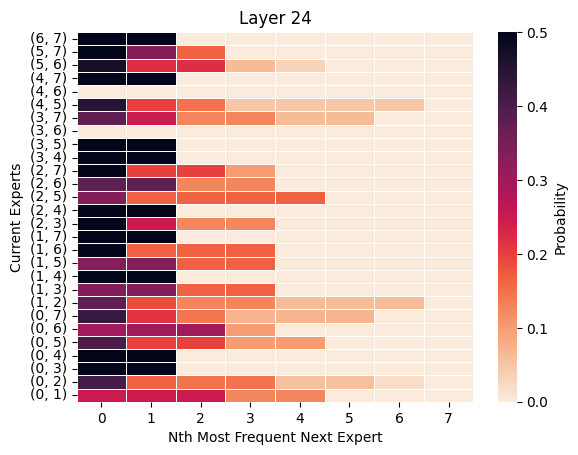

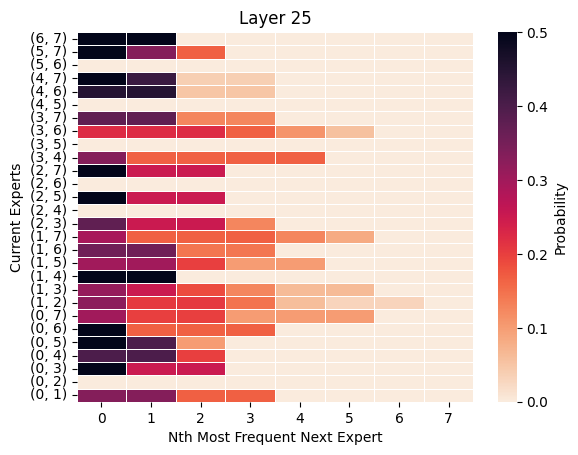

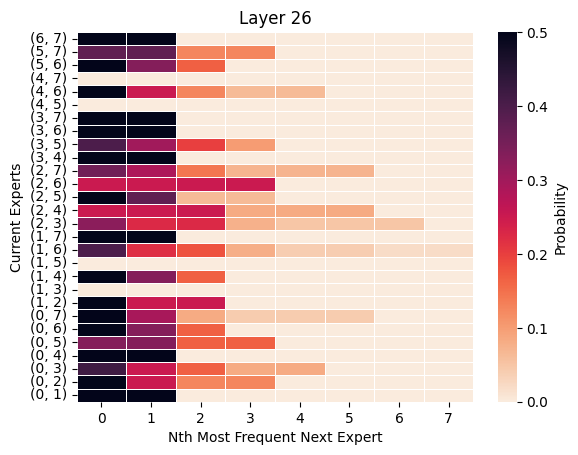

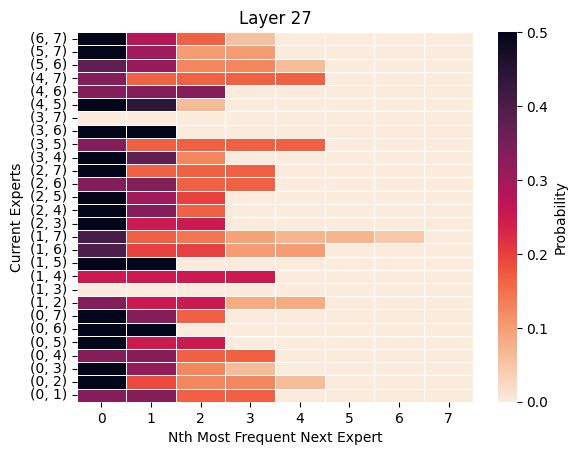

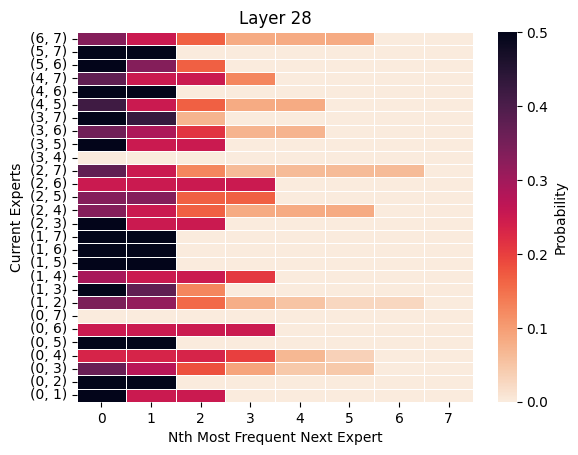

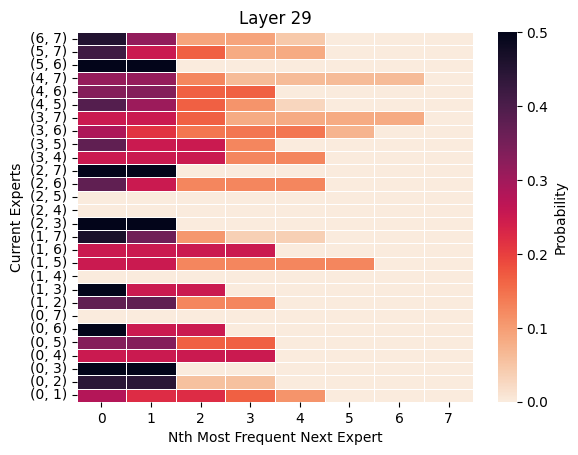

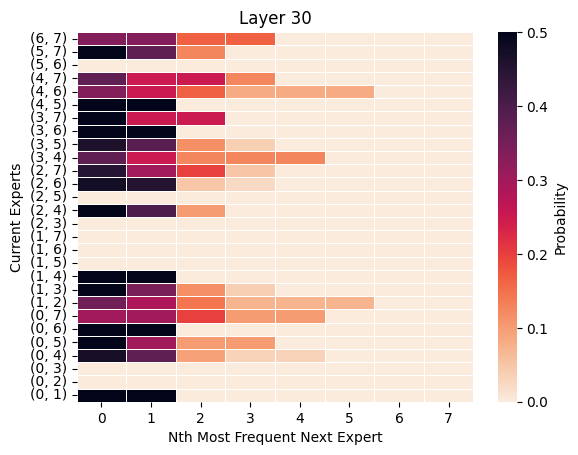

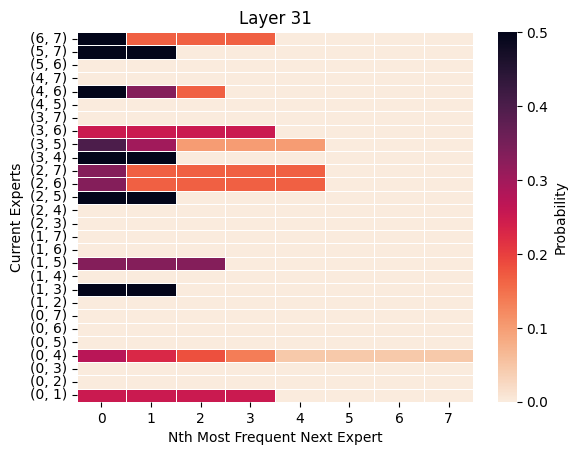

In [546]:
single_trace = {files[0]: traces[files[0]]}
probabilities, experts_to_idx = p_next_expert_given_previous_experts(single_trace)
sorted_probabilities = np.sort(probabilities, axis=-1)[:, :, ::-1]

def plot_probabilities(layer_id, probabilities, experts_to_idx):
    ax = sns.heatmap(probabilities[layer_id], linewidths=.5, cmap='rocket_r',
                     cbar_kws={'label': 'Probability'}, vmin=0)
    ax.invert_yaxis()
    plt.xlabel("Nth Most Frequent Next Expert")
    plt.ylabel("Current Experts")
    plt.title(f"Layer {layer_id}")
    
    yticks = np.arange(0, len(experts_to_idx), 1)
    idx_to_experts = {i: e for e, i in experts_to_idx.items()}
    yticklabels = [idx_to_experts[i] for i in yticks]
    ax.set_yticks(yticks + 0.5, yticklabels)
    # plt.xticks(fontsize=5)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()

for i in range(32):
    plot_probabilities(i, sorted_probabilities, experts_to_idx)

# Principal Component Analysis

In [547]:
# PCA with all sequences truncated to minimum sequence length.
def sequence_of_experts(trace: QueryTrace) -> Sequence[Sequence[int]]:
    experts = itertools.chain.from_iterable(trace.expert_ids)
    return [tuple(sorted(e)) for e in experts]

expert_sequences = []
for trace in traces.values():
    experts = sequence_of_experts(trace)
    expert_ids = [experts_to_idx[e] for e in experts]

    expert_sequences.append(expert_ids)

Text(0.5, 1.0, 'Singular Values')

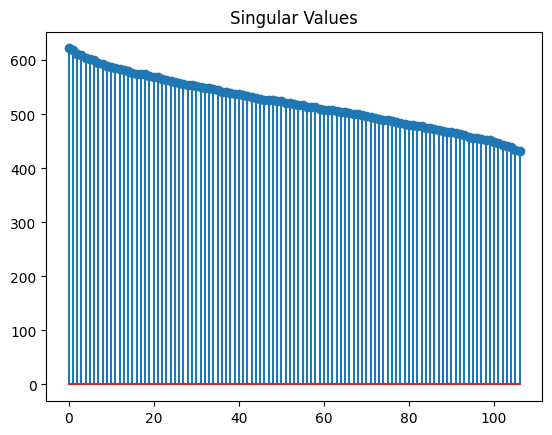

In [558]:
min_token_length = min(t.num_tokens for t in traces.values())

truncated_expert_sequences = np.array([e[:min_token_length] for e in expert_sequences])
demeaned = truncated_expert_sequences - truncated_expert_sequences.mean(axis=-1)[:, np.newaxis]

U, s, Vt = np.linalg.svd(demeaned)

plt.stem(s)
plt.title("Singular Values")

# Poor Man's Attempt at a Frequency Analysis

In [507]:
def sequence_of_experts(trace: QueryTrace) -> Sequence[Sequence[int]]:
    experts = itertools.chain.from_iterable(trace.expert_ids)
    return [tuple(sorted(e)) for e in experts]

expert_sequences = []
for trace in traces.values():
    experts = sequence_of_experts(trace)
    expert_ids = [experts_to_idx[e] for e in experts]

    expert_sequences.append(expert_ids)

    # f, Pxx_den = signal.periodogram(expert_ids)

    # plt.figure()
    # plt.semilogy(f, Pxx_den)
    # plt.plot()

In [513]:
pxx_densities = [] # per sequence

for s in expert_sequences:
    f, pxx_den = signal.periodogram(s)
    pxx_densities.append(pxx_den)

pxx_densities_per_token = []
for token_idx in range(max(map(len, expert_sequences))):
    per_token_densities = []
    for seq in expert_sequences:
        if token_idx < len(seq):
            per_token_densities.append(seq[token_idx])
    pxx_densities_per_token.append(per_token_densities)

4096
102720


Text(0.5, 1.0, 'Variance of Power Spectral Density across Sequences')

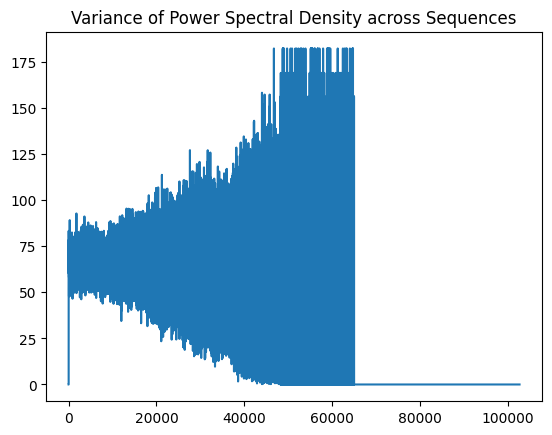

In [544]:
max_tokens = len(pxx_densities_per_token[0])
min_tokens = min(t.num_tokens for t in traces.values())
print(min_tokens)
print(max(t.num_tokens for t in traces.values()))
# Variance
vars = [np.var(s) for s in pxx_densities_per_token]
sns.lineplot(vars)
plt.title("Variance of Power Spectral Density across Sequences")

<Axes: >

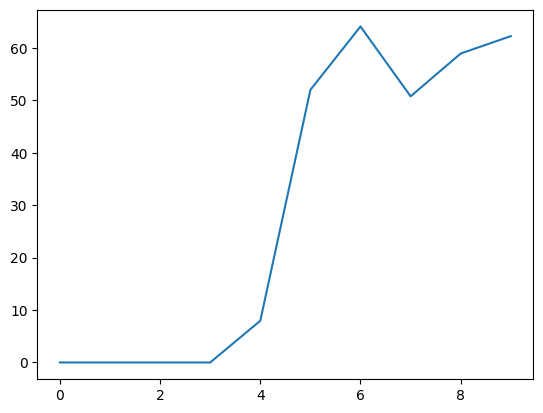

In [543]:
sns.lineplot(vars[:10])

In [541]:
pxx_densities_per_token[4]

[20,
 20,
 20,
 20,
 20,
 8,
 13,
 13,
 13,
 20,
 13,
 18,
 20,
 19,
 13,
 20,
 20,
 20,
 19,
 20,
 19,
 19,
 20,
 13,
 20,
 20,
 13,
 13,
 18,
 13,
 20,
 13,
 20,
 13,
 18,
 20,
 20,
 18,
 13,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 18,
 20,
 20,
 19,
 18,
 13,
 19,
 20,
 20,
 20,
 20,
 20,
 18,
 13,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 13,
 20,
 8,
 20,
 20,
 20,
 20,
 20,
 19,
 13,
 20,
 20,
 20,
 19,
 20,
 19,
 20,
 19,
 19,
 19,
 19,
 20,
 20,
 19,
 19,
 20,
 19,
 20,
 20,
 20,
 20,
 19,
 20,
 20,
 19]

In [536]:
vars[1]

0.0

<Axes: ylabel='Proportion'>

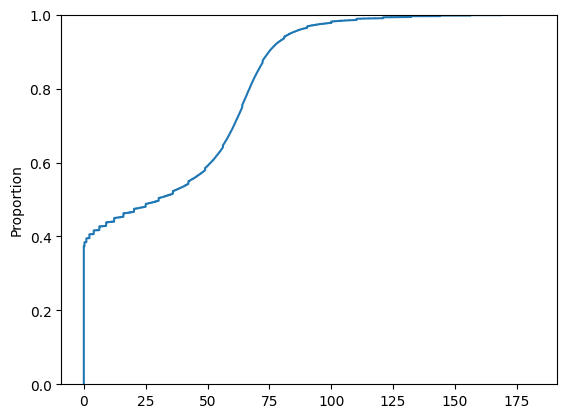

In [523]:
sns.ecdfplot(vars)

In [521]:
vars

[0.0,
 0.0,
 0.0,
 0.0,
 7.963315573412524,
 52.01781815005677,
 64.11424578565814,
 50.78155297405886,
 58.95292165254608,
 62.271464756747314,
 83.29565900952048,
 50.41837715084288,
 66.88776312341689,
 67.06699275045855,
 59.776224997816406,
 65.2586252074417,
 64.03179316970915,
 66.78731766966547,
 57.49218272338196,
 77.42912044720063,
 66.84636212769674,
 47.064197746528095,
 75.31766966547296,
 53.815879116080005,
 70.38693335662504,
 67.12429033103328,
 63.856231985326225,
 70.87064372434274,
 53.989868110752035,
 67.41007948292426,
 63.8459254083326,
 56.40108306402306,
 57.1307537776225,
 56.581011442047334,
 71.82146912394096,
 53.621975718403355,
 65.97991090924971,
 63.847497598043496,
 65.86915887850468,
 72.97266136780506,
 72.25609223512971,
 66.19809590357237,
 65.48100270766007,
 63.814830989606065,
 60.99764171543366,
 70.27024194252773,
 64.91501441173901,
 63.02052581011443,
 73.20324919206917,
 60.065158529129185,
 78.57839112586251,
 68.33382828194603,
 68.5139

In [372]:
# Calculate probabilities
sums = counts.sum(axis=-1)
divisor = np.maximum(np.ones_like(sums), sums) # Avoid dividing by 0.
probabilities = counts / divisor[:, np.newaxis]

In [441]:
probabilities

array([[[0.16666667, 0.08333333, 0.05555556, ..., 0.16666667,
         0.36111111, 0.05555556],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.        , 0.5       , 0.        , ..., 0.5       ,
         0.        , 0.        ],
        ...,
        [0.22222222, 0.11111111, 0.05555556, ..., 0.22222222,
         0.05555556, 0.22222222],
        [0.3       , 0.05      , 0.05      , ..., 0.15      ,
         0.05      , 0.        ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.0625    , 0.25      , 0.125     , ..., 0.0625    ,
         0.125     , 0.0625    ],
        [0.13636364, 0.04545455, 0.13636364, ..., 0.09090909,
         0.13636364, 0.18181818],
        [0.3       , 0.3       , 0.        , ..., 0.2       ,
         0.1       , 0.        ],
        ...,
        [0.1       , 0.1       , 0.1       , ..., 0.1       ,
         0.1       , 0.2       ],
        [0.1

In [385]:
len(list(itertools.combinations(list(range(8)), 2)))

28

In [383]:
itertools.combinations?

Init signature: itertools.combinations(iterable, r)
Docstring:     
Return successive r-length combinations of elements in the iterable.

combinations(range(4), 3) --> (0,1,2), (0,1,3), (0,2,3), (1,2,3)
Type:           type
Subclasses:     

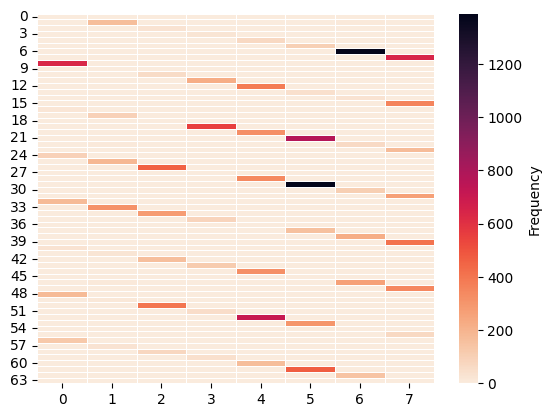

In [375]:
probabilities.shape

ax = sns.heatmap(probabilities[0].reshape(64, 8), linewidths=.5, cmap='rocket_r',
                 cbar_kws={'label': 'Frequency'})

Text(50.722222222222214, 0.5, 'Layer')

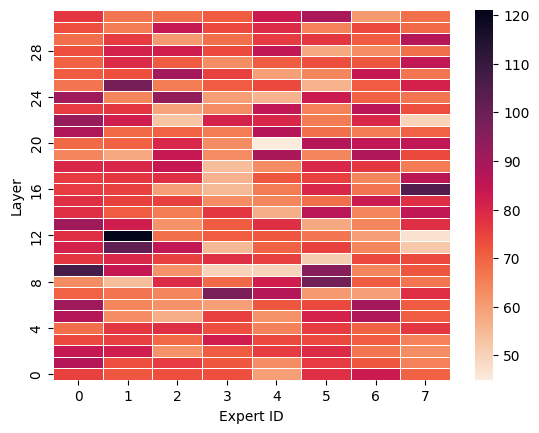

In [314]:
num_layers = len(np.unique(layer_ids))
# print('num_layers', num_layers)

num_experts = len(np.unique(list(itertools.chain.from_iterable(itertools.chain.from_iterable(expert_ids)))))
# print('num_experts', num_experts)

expert_counts_by_layer = np.zeros((num_layers, num_experts))
for layer_id, exp_ids in zip(layer_ids, expert_ids):
    # print(np.unique(exp_ids, return_counts=True))
    exp_ids_flat = list(itertools.chain.from_iterable(exp_ids))
    # print(np.bincount(exp_ids_flat + list(range(num_experts))) - 1)
    counts = np.bincount(exp_ids_flat + list(range(num_experts))) - 1 # Ensure all experts are included.
    expert_counts_by_layer[layer_id] += np.bincount(exp_ids_flat + list(range(num_experts)))

# print(expert_counts_by_layer.sum(axis=1))
ax = sns.heatmap(expert_counts_by_layer, linewidths=.5, cmap='rocket_r')
ax.invert_yaxis()
ax.set_yticks(0.5 + np.arange(0, 32, 4), np.arange(0, 32, 4))
plt.xlabel("Expert ID")
plt.ylabel("Layer")

In [358]:
counts.sum(axis=-1).shape

(32, 8, 8)

In [359]:
counts.shape

(32, 8, 8, 8)

In [345]:
trace = traces['MTBench-Mixtral/139916901616816.txt']
for i, x in enumerate([len(e_ids) for e_ids in trace.expert_ids]):
    if x > 1:
        print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647


In [328]:
a = np.zeros((2, 2, 2))
a[0, [0, 1], 0] += 1
a[0, :, 0]

array([1., 1.])

In [150]:
@dataclass(frozen=True)
class Invocation:
    layer_id: int
    input_ids: np.ndarray
    expert_ids: np.ndarray

def groupby_invocations(layer_ids, input_ids, expert_ids):
    return [
            Invocation(
                layer_id=layer_id,
                input_ids=np.array(inp_ids),
                expert_ids=np.array(exp_ids),
            )
            for layer_id, inp_ids, exp_ids in zip(layer_ids, input_ids, expert_ids)
        ]

invocations = groupby_invocations(layer_ids, input_ids, expert_ids)

In [74]:
invocations[0] 

Invocation(layer_id=0, input_ids=array([    1,   733, 16289, 28793,  9595,  1707,  1235,   459,  6847,
         395,   272,  2663, 28804,    13,   884,   267, 28725,  2710,
        2131, 10297, 28725,  1253, 28725,  4456,   733, 28748, 16289,
       28793,   415,  1707,   369,  1235,   459,  6847,   395,   272,
        2663,   349,   345,  6602,   611,   415,   799,  3085,   460,
         544,  5099,   302,   264,  1253,   325, 28707,   536, 28725,
        2710,  2131, 10297, 28731,   442,   264,  1587,  2373,   264,
        1253,   325, 11358,   609,     2,   733, 16289, 28793, 13955,
         368,  9013,   378,   395,   264,  1707,   369, 17827,   395,
         272,  2663, 28804,   733, 28748, 16289, 28793]), expert_ids=array([[5, 1],
       [5, 2],
       [6, 5],
       [2, 5],
       [3, 6],
       [6, 2],
       [1, 0],
       [6, 4],
       [4, 6],
       [5, 0],
       [7, 5],
       [2, 6],
       [0, 1],
       [7, 0],
       [6, 2],
       [5, 0],
       [6, 0],
       [3, 5]